In [ ]:
from numpy import expand_dims
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import shutil
from PIL import Image
import zipfile
import os
import io

from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
from tensorflow.keras.applications import mobilenet_v2
from keras import backend as K
from keras.callbacks import Callback

Upload dataset to Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the file

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Spiced_Project/oversampling.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

# ResNet152 Model

In [ ]:
classes = ['normal','diabetic', 'glaucoma', 'hypertensive', 'myopia', 'cataract']
base_path = '/tmp/oversampling/'

In [ ]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=keras.applications.resnet.preprocess_input,
    #rescale=1/255,   
)

In [ ]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=3000,  ## note: it's really images: 100 per category. this is mostly only working for models with transfer learning
        target_size=(224, 224)
)

Found 3000 images belonging to 6 classes.


In [ ]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((3000, 224, 224, 3), (3000, 6))

In [ ]:

classes

['normal', 'diabetic', 'glaucoma', 'hypertensive', 'myopia', 'cataract']

In [ ]:
ytrain.shape

(3000, 6)

# ResNet152 Model

In [ ]:
K.clear_session()

In [ ]:
resnet_model = Sequential()

pretrained_model=keras.applications.ResNet152(
      include_top=False,
      weights=None,
      input_tensor=None,
      input_shape=(224, 224, 3),
      pooling='max',
      classes=6,
      classifier_activation='softmax',
  )

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
 

In [ ]:
#resnet_model.add(Flatten())
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dense(6, activation='softmax'))

# Model Summary

In [ ]:
# Check the summary:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dense_6 (Dense)             (None, 6)                 1

# Run the Model

In [ ]:
# Compile the model
#opt = keras.optimizers.Adam(learning_rate=0.01)
resnet_model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])#opt)

In [ ]:
checkpoint = ModelCheckpoint("best_model_ResNet152.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq=1)

In [ ]:
# Early stopping:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=30, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    mode='auto'  
)

In [ ]:
# Fit the model
history = resnet_model.fit(xtrain,ytrain,batch_size=40, epochs=200,validation_split=0.2, callbacks = [early_stop])#, checkpoint])

Epoch 1/200
60/60 [==============================] - 43s 409ms/step - loss: 33.9489 - accuracy: 0.1558 - val_loss: 2.0494 - val_accuracy: 0.1717
Epoch 2/200
60/60 [==============================] - 22s 370ms/step - loss: 1.8695 - accuracy: 0.2046 - val_loss: 1.7412 - val_accuracy: 0.2117
Epoch 3/200
60/60 [==============================] - 23s 379ms/step - loss: 1.7489 - accuracy: 0.2171 - val_loss: 1.9282 - val_accuracy: 0.2450
Epoch 4/200
60/60 [==============================] - 23s 385ms/step - loss: 1.7270 - accuracy: 0.2592 - val_loss: 1.6686 - val_accuracy: 0.2400
Epoch 5/200
60/60 [==============================] - 22s 370ms/step - loss: 1.6712 - accuracy: 0.2788 - val_loss: 1.6563 - val_accuracy: 0.2433
Epoch 6/200
60/60 [==============================] - 23s 384ms/step - loss: 1.6290 - accuracy: 0.2929 - val_loss: 1.7801 - val_accuracy: 0.2567
Epoch 7/200
60/60 [==============================] - 23s 385ms/step - loss: 1.6274 - accuracy: 0.3038 - val_loss: 1.6481 - val_accuracy

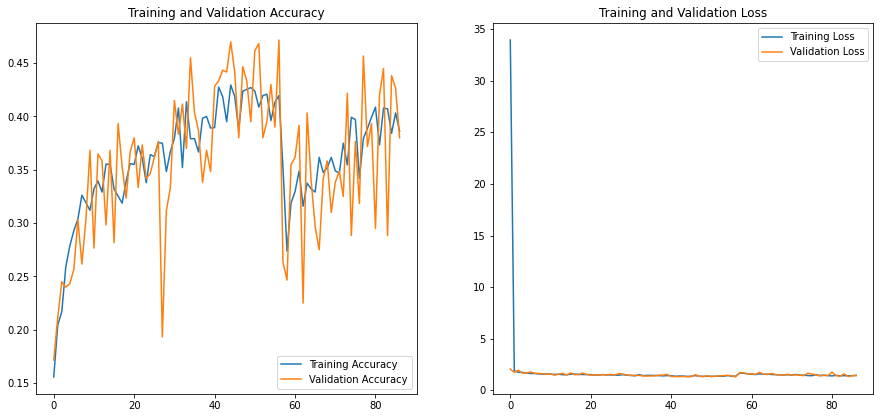

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(87)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

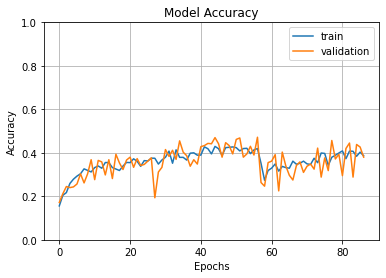

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()